## Table of Contents

1. [Imports and GPU Detection](#imports-and-gpu-detection)
2. [A Synthetic Dataset](#a-synthetic-dataset)
3. [Scaling the Data](#scaling-the-data)
4. [Baseline Neural Network](#baseline-neural-network)
5. [Define the Neural Architecture Search Space](#define-the-neural-architecture-search-space)
6. [Define the Neural Architecture Search Optimization Problem](#define-the-neural-architecture-search-optimization-problem)
7. [Start Ray](#Start-Ray)
8. [Define the Evaluator Object](#Define-the-Evaluator-Object)
9. [Define and Run the Neural Architecture Search](#Define-and-Run-the-Neural-Architecture-Search)
10. [Adding Uncertainty Quantification to the Baseline Neural Network](#Adding-Uncertainty-Quantification-to-the-Baseline-Neural-Network)
11. [Ensemble of Reural Networks With Random Initialization](#Ensemble-of-Reural-Networks-With-Random-Initialization)
12. [AutoDEUQ: Automated Deep Ensemble with Uncertainty Quantification](#AutoDEUQ:-Automated-Deep-Ensemble-with-Uncertainty-Quantification)

## Imports and GPU Detection <a class="anchor" id="imports-and-gpu-detection"></a>

<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

In [1]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [2]:
import json
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to avoid the logging of Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(3)

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to detect if **GPU** devices are available on the current host.
    
</div>

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]

n_gpus = len(get_available_gpus())
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


## A Synthetic Dataset <a class="anchor" id="a-synthetic-dataset"></a>

Now, we will start by defining our artificial dataset based on a Sinus curve. We will first generate data for a **training set** (used for estimation) and a **testing set** (used to evaluate the final performance). Then the training set will be sub-divided in a new **training set** (used to estimate the neural network weights) and **validation set** (used to estimate the neural network hyperparameters and architecture). The data are generated from the following function:

$$ y = f(x) = 2 \cdot \sin(x) + \epsilon$$

The training data will be generated in a range between $[-30, -20]$ with $\epsilon \sim \mathcal{N}(0,0.25)$ and  in a range between $[20, 30]$ with $\epsilon \sim \mathcal{N}(0,1)$. The code for the training data is then corresponding to:

In [5]:
def load_data_train_test(random_state=42):
    rs = np.random.RandomState(random_state)

    train_size = 400
    f = lambda x: 2*np.sin(x) # a simlpe affine function

    x_1 = rs.uniform(low=-30, high=-20.0, size=train_size//2)
    eps_1 = rs.normal(loc=0.0, scale=0.5, size=train_size//2)
    y_1 = f(x_1) + eps_1

    x_2 = rs.uniform(low=20.0, high=30.0, size=train_size//2)
    eps_2 = rs.normal(loc=0.0, scale=1.0, size=train_size//2)
    y_2 = f(x_2) + eps_2

    x = np.concatenate([x_1, x_2], axis=0)
    y = np.concatenate([y_1, y_2], axis=0)

    x_tst = np.linspace(-40.0, 40.0, 200)
    y_tst = f(x_tst)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    x_tst = x_tst.reshape(-1, 1)
    y_tst = y_tst.reshape(-1, 1)

    return (x, y), (x_tst, y_tst)

Then the code to split the training data in a new **training set** and a **validation set** corresponds to:

In [6]:
from sklearn.model_selection import train_test_split

def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state
    )

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)


(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx , ty) = load_data_train_test()

train_X shape: (268, 1)
train_y shape: (268, 1)
valid_X shape: (132, 1)
valid_y shape: (132, 1)


<div class="alert alert-info">
    
<b>Note</b>
    
When it is possible to factorize the two previous function into one, DeepHyper interface requires a function which returns `(train_inputs, train_outputs), (valid_inputs, valid_outputs)`.
    
</div>

We can give a visualization of this data:

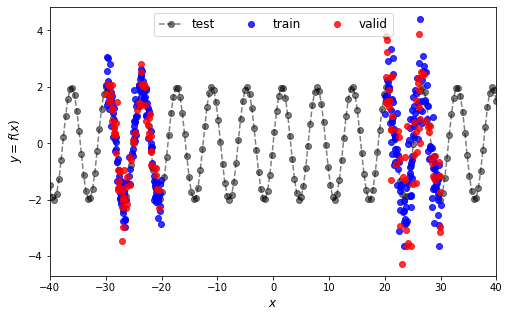

In [7]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx.reshape(-1), ty.reshape(-1), "ko--", label="test", alpha=0.5)
plt.plot(x.reshape(-1), y.reshape(-1), "bo", label="train", alpha=0.8)
plt.plot(vx.reshape(-1), vy.reshape(-1), "ro", label="valid", alpha=0.8)

plt.ylabel("$y = f(x)$", fontsize=12)
plt.xlabel("$x$", fontsize=12)

plt.xlim(-40, 40)
plt.legend(loc="upper center", ncol=3, fontsize=12)

plt.show()

## Scaling the Data <a class="anchor" id="scaling-the-data"></a>

It is important to apply standard scaling on the input/output data to have faster convergence when training.

In [8]:
from sklearn.preprocessing import StandardScaler


scaler_x = StandardScaler()
s_x = scaler_x.fit_transform(x)
s_vx = scaler_x.transform(vx)
s_tx = scaler_x.transform(tx)

scaler_y = StandardScaler()
s_y = scaler_y.fit_transform(y)
s_vy = scaler_y.transform(vy)
s_ty = scaler_y.transform(ty)

## Baseline Neural Network <a class="anchor" id="baseline-neural-network"></a>

Let us define a baseline neural network based on a regular multi-layer perceptron architecture which learn the mean estimate and minimise the mean squared error.

In [9]:
input_ = tf.keras.layers.Input(shape=(1,))
out = tf.keras.layers.Dense(200, activation="relu")(input_)
out = tf.keras.layers.Dense(200, activation="relu")(out)
output = tf.keras.layers.Dense(1)(out)
model = tf.keras.Model(input_, output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, "mse")

history = model.fit(s_x, s_y, epochs=200, batch_size=4, validation_data=(s_vx, s_vy), verbose=1)

Epoch 1/200
67/67 [==============================] - 1s 3ms/step - loss: 1.0336 - val_loss: 1.0670
Epoch 2/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0039 - val_loss: 1.1085
Epoch 3/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0118 - val_loss: 1.0674
Epoch 4/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0214 - val_loss: 1.0743
Epoch 5/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0089 - val_loss: 1.0741
Epoch 6/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0043 - val_loss: 1.0698
Epoch 7/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0038 - val_loss: 1.0757
Epoch 8/200
67/67 [==============================] - 0s 1ms/step - loss: 0.9981 - val_loss: 1.0730
Epoch 9/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0017 - val_loss: 1.0706
Epoch 10/200
67/67 [==============================] - 0s 1ms/step - loss: 0.9990 - val_loss: 1.0728
Epoch 11/

Epoch 83/200
67/67 [==============================] - 0s 1ms/step - loss: 0.7370 - val_loss: 0.7923
Epoch 84/200
67/67 [==============================] - 0s 1ms/step - loss: 0.7229 - val_loss: 0.7485
Epoch 85/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6919 - val_loss: 0.7416
Epoch 86/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6764 - val_loss: 0.7259
Epoch 87/200
67/67 [==============================] - 0s 998us/step - loss: 0.6747 - val_loss: 0.7465
Epoch 88/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6620 - val_loss: 0.7673
Epoch 89/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6640 - val_loss: 0.7262
Epoch 90/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6561 - val_loss: 0.6861
Epoch 91/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6516 - val_loss: 0.6758
Epoch 92/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6406 - val_loss: 0.694

67/67 [==============================] - 0s 1ms/step - loss: 0.3196 - val_loss: 0.3795
Epoch 165/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3172 - val_loss: 0.4181
Epoch 166/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3316 - val_loss: 0.4246
Epoch 167/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3332 - val_loss: 0.4139
Epoch 168/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3237 - val_loss: 0.3929
Epoch 169/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3208 - val_loss: 0.4321
Epoch 170/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3065 - val_loss: 0.4414
Epoch 171/200
67/67 [==============================] - 0s 1ms/step - loss: 0.2888 - val_loss: 0.4513
Epoch 172/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3112 - val_loss: 0.3622
Epoch 173/200
67/67 [==============================] - 0s 1ms/step - loss: 0.2981 - val_loss: 0.3677
Epoc

We can do a vizualisation of our learning curves to make sure the training and validation loss decrease correctly.

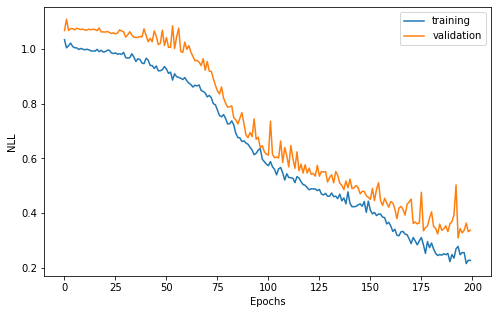

In [10]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")

plt.xlabel("Epochs")
plt.ylabel("NLL")

plt.legend()

plt.show()

Also, let us look at the prediction on the test set after reversing the scaling of predicted variables.

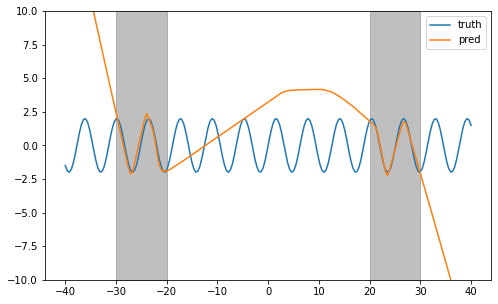

In [11]:
pred_s_ty = model(s_tx)
pred_ty = scaler_y.inverse_transform(pred_s_ty)

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty, label="pred")

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

## Define the Neural Architecture Search Space <a class="anchor" id="define-the-neural-architecture-search-space"></a>

The neural architecture search space is composed of discrete decision variables. For each decision variable we choose among a list of possible operation to perform (e.g., fully connected, ReLU). To define this search space, it is necessary to use two classes:

* `KSearchSpace` (for Keras Search Space): represents a directed acyclic graph (DAG) in which each node represents a chosen operation. It represents the possible neural networks that can be created.
* `SpaceFactory`: is a utilitiy class used to pack the logic of a search space definition and share it with others.

Then, inside a `KSearchSpace` we will have two types of nodes:
* `VariableNode`: corresponds to discrete decision variables and are used to define a list of possible operation.
* `ConstantNode`: corresponds to fixed operation in the search space (e.g., input/outputs)

Finally, it is possible to reuse any `tf.keras.layers` to define a `KSearchSpace`. However, it is important to wrap each layer in an `operation` to perform a lazy memory allocation of tensors.

In [12]:
import collections

from deephyper.nas.space import KSearchSpace, SpaceFactory

# Decision variables are represented by nodes in a graph
from deephyper.nas.space.node import ConstantNode, VariableNode

# For Skip/Residual connections
from deephyper.nas.space.op.basic import Zero
from deephyper.nas.space.op.connect import Connect
from deephyper.nas.space.op.merge import AddByProjecting

from deephyper.nas.space.op.op1d import Identity

# The "operation" creates a wrapper around Keras layers
# to avoid allocating memory each time a new layer is defined
# in the search space
from deephyper.nas.space.op import operation

Dense = operation(tf.keras.layers.Dense)

# Possible activation functions
ACTIVATIONS = [
    tf.keras.activations.elu,
    tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]

We implement the `build` method of the `RegressionFactory` which is a subclass of `SpaceFactory`. The `build` method interface is:

```python
def build(self, input_shape, output_shape, **kwargs) -> KSearchSpace:
    ...
```

where:
* `input_shape` corresponds to a tuple or a list of tuple indicating the shapes of inputs tensors.
* `output_shape` corresponds to the same but of output_tensors.
* `**kwargs` denotes that any other key word argument can be defined by the user.

This method has to return an object of type `KSearchSpace`.

In [13]:
class RegressionFactory(SpaceFactory):
    
    def build(self, input_shape, output_shape, num_layers=3, **kwargs):

        self.ss = KSearchSpace(input_shape, output_shape)
        
        # After creating a KSearchSpace nodes corresponds to the inputs are directly accessible
        out_sub_graph = self.build_sub_graph(self.ss.input_nodes[0], num_layers)

        output = ConstantNode(op=Dense(output_shape[0]))  
        self.ss.connect(out_sub_graph, output)

        return self.ss

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.ss.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self.ss, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self.ss, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.ss.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))


def create_search_space(input_shape=(1,), output_shape=(1,), **kwargs):
    return RegressionFactory()(input_shape, output_shape, **kwargs)

Let us visualize a few randomly sampled neural architecture from this search space.

<div class="alert alert-warning">

<b>Warning</b>
    
To execute the following it is necessary to have `pydot` and `graphviz` installed. A possibility is to have a conda environment and do:
    
```console
pip install pydot
conda install graphviz
```
    
</div>

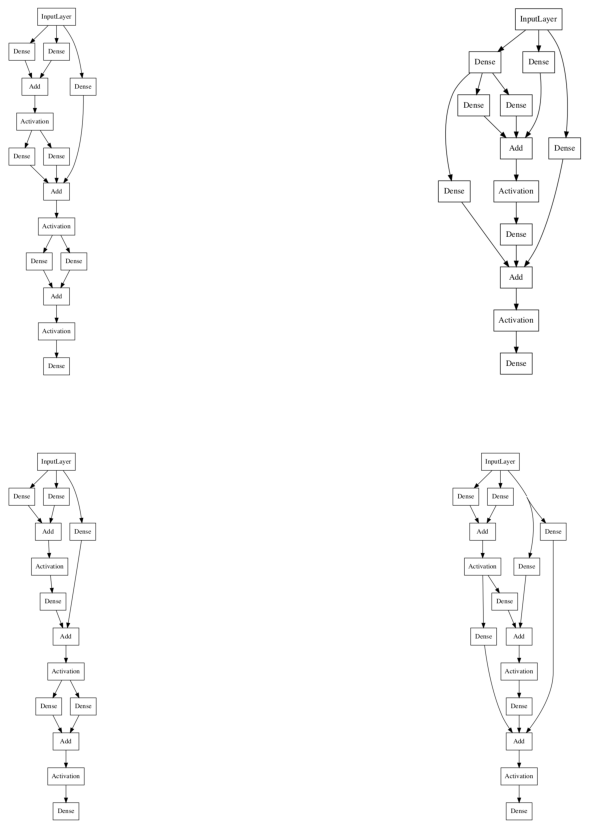

In [14]:
import matplotlib.image as mpimg

shapes = dict(input_shape=(1,), output_shape=(1,))
factory = RegressionFactory()

images = []
plt.figure(figsize=(15,15))
for i in range(4):

    plt.subplot(2,2,i+1)
    factory.plot_model(**shapes, show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Define the Neural Architecture Optimization Problem <a class="anchor" id="define-the-neural-architecture-search-optimization-problem"></a>

In order to define a neural architecture search problem we have to use the `NaProblem` class. This class gives access to different method for the user to customize the training settings of neural networks.

In [15]:
from deephyper.problem import NaProblem


def stdscaler():
    return StandardScaler()


problem = NaProblem()

# Bind a function which returns (train_input, train_output), (valid_input, valid_output)
problem.load_data(load_data_train_valid)

# Bind a function which return a scikit-learn preprocessor (with fit, fit_transform, inv_transform...etc)
problem.preprocessing(stdscaler)

# Bind a function which returns a search space and give some arguments for the `build` method
problem.search_space(create_search_space, num_layers=3)

# Define a set of fixed hyperparameters for all trained neural networks
problem.hyperparameters(
    batch_size=4,
    learning_rate=1e-3,
    optimizer="adam",
    num_epochs=200,
    callbacks=dict(
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
    ),
)

# Define the loss to minimize
problem.loss("mse")

# Define complementary metrics
problem.metrics([])

# Define the maximized objective. Here we take the negative of the validation loss.
problem.objective("-val_loss")

problem

Problem is:
 * SEED = None *
    - search space   : __main__.create_search_space
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : __main__.stdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: 4
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 200
        * callbacks: {'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 30}}
    - loss           : mse
    - metrics        : 
    - objective      : -val_loss
    - post-training  : None

<div class="alert alert-info">
    
<b>Tip</b>
    
Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
...
```
    
</div>



## Start Ray

We launch the Ray run-time depending on the detected local ressources. If GPU(s) is(are) detected then 1 worker is started for each GPU. If not, then only 1 worker is started. You can start more workers by setting `num_cpus=1` to a value greater than 1.

<div class="alert alert-warning">

<b>Warning</b>
    
In the case of GPUs it is important to follow this scheme to avoid multiple processes (Ray workers vs current process) to lock the same GPU.
    
</div>

In [16]:
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=1, log_to_driver=False)

2021-09-29 13:04:28,334	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


## Define the Evaluator Object

The `Evaluator` object is responsible of defining the backend used to distribute the function evaluation in DeepHyper.

In [17]:
from deephyper.evaluator.evaluate import Evaluator
from deephyper.evaluator.callback import LoggerCallback


def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()] # To interactively follow the finished evaluations
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

For neural architecture search a standard training pipeline is provided by the `deephyper.nas.run.alpha.run` function.

In [18]:
from deephyper.nas.run.alpha import run as run_nas

## Define and Run the Neural Architecture Search

All search algorithms follow a similar interface. A `problem` and `evaluator` object has to be provided to the search then the search can be executed through the `search(max_evals, timeout)` method.

In [19]:
results = {} # used to store the results of different search algorithms
max_evals = 250 # maximum number of iteratins for all searches

In [20]:
from deephyper.search.nas.random import Random

random_search = Random(problem, get_evaluator(run_nas))

results["random"] = random_search.search(max_evals=max_evals)

Created new evaluator with 4 workers and config: {'num_cpus': 4, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7f81dc859190>]}
[00001] -- best objective: -1.087670087814331 -- received objective: -1.087670087814331
[00002] -- best objective: -1.038583755493164 -- received objective: -1.038583755493164
[00003] -- best objective: -1.038583755493164 -- received objective: -1.0760248899459839
[00004] -- best objective: -0.36526185274124146 -- received objective: -0.36526185274124146
[00005] -- best objective: -0.3521248400211334 -- received objective: -0.3521248400211334
[00006] -- best objective: -0.3521248400211334 -- received objective: -1.0658371448516846
[00007] -- best objective: -0.3521248400211334 -- received objective: -1.0764837265014648
[00008] -- best objective: -0.3245546817779541 -- received objective: -0.3245546817779541
[00009] -- best objective: -0.3245546817779541 -- received objective: -1.0772676467895508
[00010] -- best o

[00091] -- best objective: -0.2935952842235565 -- received objective: -0.3926234543323517
[00092] -- best objective: -0.2935952842235565 -- received objective: -1.0692237615585327
[00093] -- best objective: -0.2935952842235565 -- received objective: -0.3172072470188141
[00094] -- best objective: -0.2935952842235565 -- received objective: -1.0479495525360107
[00095] -- best objective: -0.2935952842235565 -- received objective: -1.0723685026168823
[00096] -- best objective: -0.2935952842235565 -- received objective: -1.081537127494812
[00097] -- best objective: -0.2935952842235565 -- received objective: -0.5562483072280884
[00098] -- best objective: -0.2935952842235565 -- received objective: -1.0751997232437134
[00099] -- best objective: -0.2935952842235565 -- received objective: -0.3163853585720062
[00100] -- best objective: -0.2935952842235565 -- received objective: -1.019927740097046
[00101] -- best objective: -0.2935952842235565 -- received objective: -0.33324185013771057
[00102] -- 

[00183] -- best objective: -0.2935952842235565 -- received objective: -0.30956465005874634
[00184] -- best objective: -0.2935952842235565 -- received objective: -1.0297930240631104
[00185] -- best objective: -0.2935952842235565 -- received objective: -0.8545525074005127
[00186] -- best objective: -0.2935952842235565 -- received objective: -1.1038036346435547
[00187] -- best objective: -0.2935952842235565 -- received objective: -0.33145901560783386
[00188] -- best objective: -0.2935952842235565 -- received objective: -1.074212670326233
[00189] -- best objective: -0.2935952842235565 -- received objective: -0.32453489303588867
[00190] -- best objective: -0.2935952842235565 -- received objective: -1.0209418535232544
[00191] -- best objective: -0.2935952842235565 -- received objective: -0.9933105111122131
[00192] -- best objective: -0.2935952842235565 -- received objective: -0.3441563844680786
[00193] -- best objective: -0.2935952842235565 -- received objective: -1.0238734483718872
[00194] 

By default, the `RegularizedEvolution` has a population size of 100 therefore, it will start optimizing only after 100 evaluations.

In [21]:
from deephyper.search.nas.regevo import RegularizedEvolution

regevo_search = RegularizedEvolution(problem, get_evaluator(run_nas))

results["regevo"] = regevo_search.search(max_evals=max_evals)

Created new evaluator with 4 workers and config: {'num_cpus': 4, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7f81de09ba60>]}
[00001] -- best objective: -1.0755410194396973 -- received objective: -1.0755410194396973
[00002] -- best objective: -1.0755410194396973 -- received objective: -1.0766122341156006
[00003] -- best objective: -1.0365856885910034 -- received objective: -1.0365856885910034
[00004] -- best objective: -0.40544983744621277 -- received objective: -0.40544983744621277
[00005] -- best objective: -0.40544983744621277 -- received objective: -1.0297236442565918
[00006] -- best objective: -0.40544983744621277 -- received objective: -0.7750799059867859
[00007] -- best objective: -0.40544983744621277 -- received objective: -1.0765266418457031
[00008] -- best objective: -0.40544983744621277 -- received objective: -1.0361745357513428
[00009] -- best objective: -0.40544983744621277 -- received objective: -1.0722209215164185
[00010]

[00090] -- best objective: -0.3023522198200226 -- received objective: -0.3681035339832306
[00091] -- best objective: -0.3023522198200226 -- received objective: -1.070300579071045
[00092] -- best objective: -0.3023522198200226 -- received objective: -1.0293941497802734
[00093] -- best objective: -0.3023522198200226 -- received objective: -1.0763839483261108
[00094] -- best objective: -0.3023522198200226 -- received objective: -1.0345102548599243
[00095] -- best objective: -0.3023522198200226 -- received objective: -1.0147966146469116
[00096] -- best objective: -0.3023522198200226 -- received objective: -0.40276002883911133
[00097] -- best objective: -0.3023522198200226 -- received objective: -0.39190512895584106
[00098] -- best objective: -0.3023522198200226 -- received objective: -0.698643147945404
[00099] -- best objective: -0.3023522198200226 -- received objective: -0.32504069805145264
[00100] -- best objective: -0.3023522198200226 -- received objective: -1.0708004236221313
[00101] -

[00181] -- best objective: -0.2895606458187103 -- received objective: -0.35532620549201965
[00182] -- best objective: -0.2895606458187103 -- received objective: -1.0344645977020264
[00183] -- best objective: -0.2895606458187103 -- received objective: -0.41740021109580994
[00184] -- best objective: -0.2895606458187103 -- received objective: -0.3455986976623535
[00185] -- best objective: -0.2895606458187103 -- received objective: -0.45431268215179443
[00186] -- best objective: -0.2895606458187103 -- received objective: -0.36990886926651
[00187] -- best objective: -0.2895606458187103 -- received objective: -0.5771023035049438
[00188] -- best objective: -0.2895606458187103 -- received objective: -0.3355792164802551
[00189] -- best objective: -0.2895606458187103 -- received objective: -1.0700446367263794
[00190] -- best objective: -0.2895606458187103 -- received objective: -1.017628788948059
[00191] -- best objective: -0.2895606458187103 -- received objective: -0.3208838999271393
[00192] --

We can now compare the search trajectories for different algorithms.

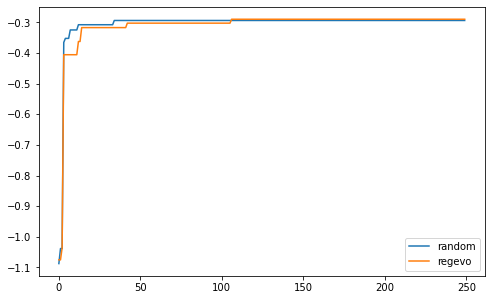

In [22]:
def max_score(l):
    r = [l[0]]
    for el in l[1:]:
        r.append(max(r[-1], el))
    return r

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

for k, result in results.items():
    plt.plot(max_score(results[k].objective), label=k)
    
plt.legend()
    
plt.show()

If we look at the dataframe of results for each search we will find it slightly different than the one of hyperparameter search. A new column `arch_seq` corresponds to an embedding for each evaluated architecture. Each integer of an `arch_seq` list corresponds to the choice of a `VariableNode` in our `KSearchSpace`.

In [23]:
results["random"]

,arch_seq,id,objective,elapsed_sec,duration
0,"[9, 1, 40, 0, 0, 57, 1, 0, 1]",1,-1.087670,8.218837,8.201864
1,"[40, 1, 1, 1, 0, 50, 1, 1, 0]",2,-1.038584,12.482604,12.465602
2,"[29, 1, 71, 0, 1, 2, 0, 0, 1]",6,-1.076025,16.284527,3.800911
3,"[32, 1, 37, 1, 1, 155, 1, 1, 0]",3,-0.365262,19.440745,19.423731
4,"[122, 1, 176, 0, 1, 78, 1, 1, 0]",4,-0.352125,21.998589,21.981567
...,...,...,...,...,...
245,"[38, 0, 99, 1, 0, 123, 0, 0, 0]",246,-0.440410,833.208567,18.694047
246,"[28, 0, 136, 0, 0, 108, 1, 1, 1]",248,-1.075365,837.700053,13.763075
247,"[105, 0, 135, 1, 0, 131, 1, 0, 1]",250,-1.075184,838.854722,5.644575
248,"[160, 0, 68, 1, 0, 125, 1, 0, 0]",247,-0.593401,840.460867,20.283473


Let us visualize the best architecture found:

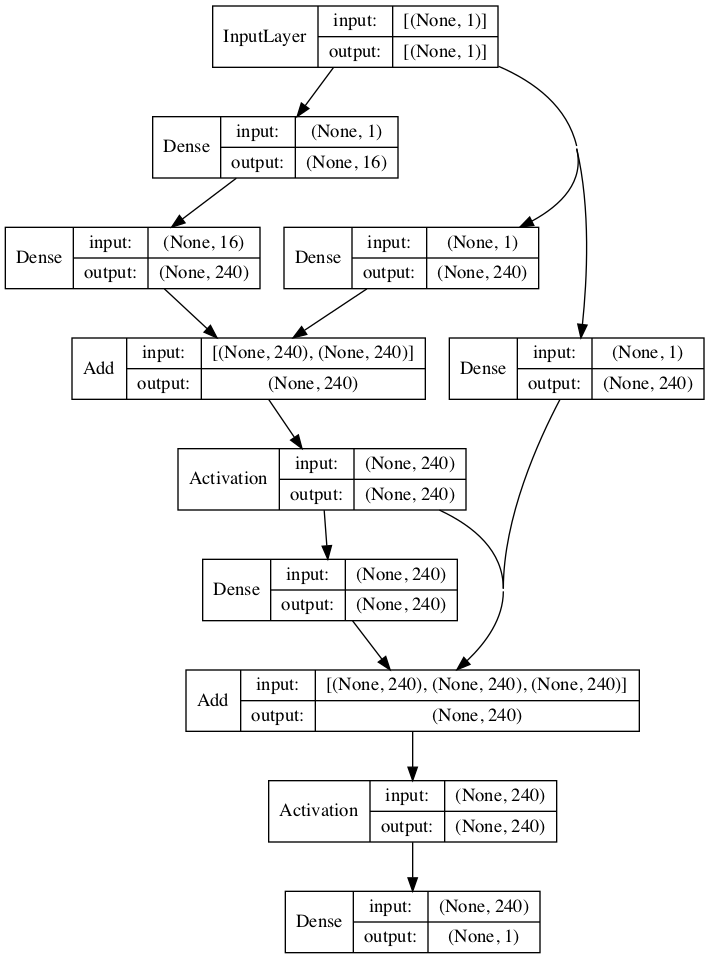

In [24]:
i_max = results["random"].objective.argmax()
best_score = results["random"].iloc[i_max].objective
best_arch_seq = json.loads(results["random"].iloc[i_max].arch_seq)

factory.plot_model(arch_seq=best_arch_seq, **shapes, show_shapes=True, show_layer_names=False)

## Adding Uncertainty Quantification to the Baseline Neural Network

In [25]:
import tensorflow_probability as tfp
tfd = tfp.distributions

To perform uncertainty quantitifcation, instead of minimising the mean squared error we will minimize the negative log-likelihood.

In [26]:
def nll(y, rv_y):
    """Negative log likelihood for Tensorflow probability."""
    return -rv_y.log_prob(y)

In [27]:
input_ = tf.keras.layers.Input(shape=(1,))
out = tf.keras.layers.Dense(200, activation="relu")(input_)
out = tf.keras.layers.Dense(200, activation="relu")(out)

# For each predicted variable (1) we need the mean and variance estimate
out = tf.keras.layers.Dense(1*2)(out) 

# We feed these estimates to output a Normal distribution for each predicted variable
output = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]), # positive constraint on the standard dev.
            )
        )(out)

model_uq = tf.keras.Model(input_, output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_uq.compile(optimizer, loss=nll)

history = model_uq.fit(s_x, s_y, epochs=200, batch_size=4, validation_data=(s_vx, s_vy), verbose=1)

Epoch 1/200
67/67 [==============================] - 1s 4ms/step - loss: 1.6057 - val_loss: 1.7064
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 1.5912 - val_loss: 1.6327
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 1.5522 - val_loss: 1.5816
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 1.5142 - val_loss: 1.5327
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 1.4705 - val_loss: 1.4866
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 1.4470 - val_loss: 1.4681
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 1.4513 - val_loss: 1.4859
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 1.4330 - val_loss: 1.4742
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 1.4256 - val_loss: 1.4749
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 1.4260 - val_loss: 1.4636
Epoch 11/

67/67 [==============================] - 0s 1ms/step - loss: 1.3966 - val_loss: 1.4432
Epoch 84/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3991 - val_loss: 1.4388
Epoch 85/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3909 - val_loss: 1.4483
Epoch 86/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4057 - val_loss: 1.4585
Epoch 87/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3922 - val_loss: 1.4433
Epoch 88/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4018 - val_loss: 1.4472
Epoch 89/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4060 - val_loss: 1.4362
Epoch 90/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3925 - val_loss: 1.4653
Epoch 91/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3988 - val_loss: 1.4334
Epoch 92/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3999 - val_loss: 1.4427
Epoch 93/200


67/67 [==============================] - 0s 1ms/step - loss: 1.3239 - val_loss: 1.3725
Epoch 165/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3073 - val_loss: 1.3604
Epoch 166/200
67/67 [==============================] - 0s 1ms/step - loss: 1.2990 - val_loss: 1.3522
Epoch 167/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3010 - val_loss: 1.3449
Epoch 168/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3008 - val_loss: 1.3603
Epoch 169/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3083 - val_loss: 1.3329
Epoch 170/200
67/67 [==============================] - 0s 1ms/step - loss: 1.2917 - val_loss: 1.3379
Epoch 171/200
67/67 [==============================] - 0s 1ms/step - loss: 1.2813 - val_loss: 1.3256
Epoch 172/200
67/67 [==============================] - 0s 1ms/step - loss: 1.2934 - val_loss: 1.3361
Epoch 173/200
67/67 [==============================] - 0s 1ms/step - loss: 1.2795 - val_loss: 1.3158
Epoc

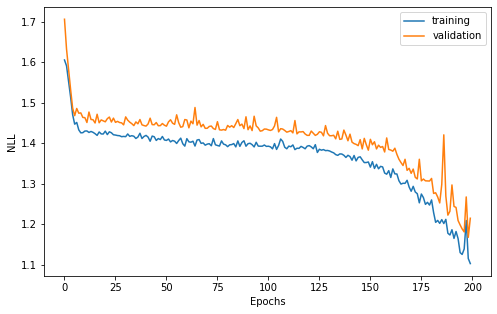

In [28]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")

plt.xlabel("Epochs")
plt.ylabel("NLL")

plt.legend()

plt.show()

Let us visualize the learned uncertainty estimates.

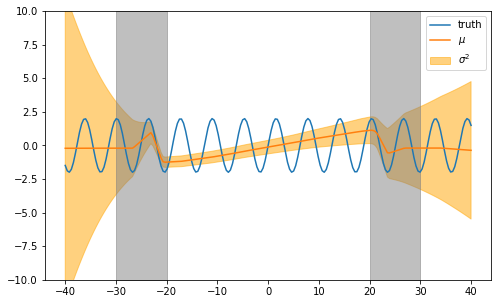

In [29]:
pred_s_ty = model_uq(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_var = np.square(pred_s_ty.scale.numpy()) * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_var).reshape(-1), 
    (pred_ty_mean + pred_ty_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$\sigma^2$"
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

The learned mean estimates appears to be worse than when minimizing the mean squared error loss. Also, we can see than the variance estimate are not meaningful in areas missing data (white background) and do not learn properly the noise in are with data (grey background).

## Ensemble of Reural Networks With Random Initialization

In [30]:
def generate_model(model_id):
    
    # Model
    input_ = tf.keras.layers.Input(shape=(1,))
    out = tf.keras.layers.Dense(200, activation="relu")(input_)
    out = tf.keras.layers.Dense(200, activation="relu")(out)
    out = tf.keras.layers.Dense(2)(out) # 1 unit for the mean, 1 unit for the scale
    output = tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :1],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]),
                )
            )(out)
    model_uq = tf.keras.Model(input_, output)
    
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models_random_init", f"{model_id}.h5"), 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True,
        save_weights_only=False, 
        mode='min', 
        save_freq='epoch'
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model_uq.compile(optimizer, loss=nll)

    history = model_uq.fit(s_x, s_y, 
                           epochs=200, 
                           batch_size=4, 
                           validation_data=(s_vx, s_vy), 
                           verbose=0,
                           callbacks=[model_checkpoint_callback]
                          )

In [31]:
if os.path.exists("models_random_init"):
    shutil.rmtree("models_random_init")
pathlib.Path("models_random_init").mkdir(parents=False, exist_ok=False)

for model_id in tqdm(range(10)):
    generate_model(model_id)

100%|██████████| 10/10 [02:14<00:00, 13.47s/it]


In [32]:
from deephyper.ensemble import UQBaggingEnsembleRegressor

ensemble = UQBaggingEnsembleRegressor(
    model_dir="models_random_init",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="topk",
)

In [33]:
ensemble.fit(s_vx, s_vy)

print(f"Selected members are: ", ensemble.members_files)

Selected members are:  ['2.h5', '9.h5', '1.h5', '7.h5', '0.h5']


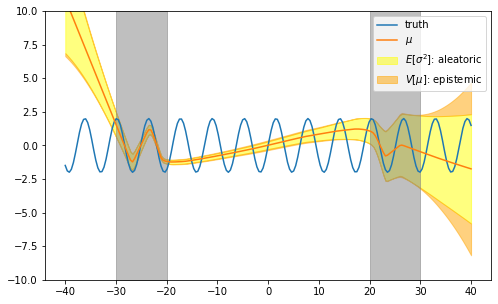

In [34]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var * scaler_y.var_
pred_ty_epistemic_var = pred_s_ty_epistemic_var * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    color="yellow", 
    alpha=0.5,
    label="$E[\sigma^2]$: aleatoric"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var - pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$V[\mu]$: epistemic"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var + pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
#     label="$V[\mu]$: epistemic"
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

## AutoDEUQ: Automated Deep Ensemble with Uncertainty Quantification

In [35]:
DistributionLambda = operation(tfp.layers.DistributionLambda)

In [36]:
class RegressionUQFactory(SpaceFactory):
    
    def build(self, input_shape, output_shape, num_layers=3, **kwargs):

        self.ss = KSearchSpace(input_shape, output_shape)

        out_sub_graph = self.build_sub_graph(self.ss.input_nodes[0], num_layers)
        
        output_dim = output_shape[0]
        output_dense = ConstantNode(op=Dense(output_dim*2))  
        self.ss.connect(out_sub_graph, output_dense)
        
        
        output_dist = ConstantNode(
            op=DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :output_dim],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., output_dim:]),
                )
            )
        )
        self.ss.connect(output_dense, output_dist)

        return self.ss

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.ss.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self.ss, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self.ss, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.ss.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))


def create_search_space_uq(input_shape=(1,), output_shape=(1,), **kwargs):
    return RegressionUQFactory()(input_shape, output_shape, **kwargs)

In [37]:
problem_uq = NaProblem()

problem_uq.load_data(load_data_train_valid)

problem_uq.preprocessing(stdscaler)

problem_uq.search_space(create_search_space_uq, num_layers=3)

problem_uq.hyperparameters(
    batch_size=problem_uq.add_hyperparameter((1, 32), "batch_size"),
    learning_rate=problem_uq.add_hyperparameter(
        (1e-4, 0.1, "log-uniform"),
        "learning_rate",
    ),
    optimizer=problem_uq.add_hyperparameter(
        ["sgd", "rmsprop", "adagrad", "adam", "adadelta", "adamax", "nadam"],
        "optimizer",
    ),
    patience_ReduceLROnPlateau=problem_uq.add_hyperparameter(
        (10, 20), "patience_ReduceLROnPlateau"
    ),
    patience_EarlyStopping=problem_uq.add_hyperparameter(
        (20, 30), "patience_EarlyStopping"
    ),
    num_epochs=200,
    callbacks=dict(
        ReduceLROnPlateau=dict(monitor="val_loss", mode="min", verbose=0, patience=5),
        EarlyStopping=dict(
            monitor="val_loss", mode="min", verbose=0, patience=10
        ),
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem_uq.loss(nll)

problem_uq.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem_uq.objective("-val_loss")

problem_uq

Problem is:
 * SEED = None *
    - search space   : __main__.create_search_space_uq
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : __main__.stdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: batch_size, Type: UniformInteger, Range: [1, 20], Default: 10
        * learning_rate: learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.0031622777, on log-scale
        * optimizer: optimizer, Type: Categorical, Choices: {sgd, rmsprop, adagrad, adam, adadelta, adamax, nadam}, Default: sgd
        * patience_ReduceLROnPlateau: patience_ReduceLROnPlateau, Type: UniformInteger, Range: [3, 30], Default: 16
        * patience_EarlyStopping: patience_EarlyStopping, Type: UniformInteger, Range: [3, 30], Default: 16
        * num_epochs: 100
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 5}, 'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 

In [38]:
results_uq = {}

In [39]:
from deephyper.search.nas.agebo import AgEBO


if os.path.exists("save"):
    shutil.rmtree("save")

agebo_search = AgEBO(problem_uq, get_evaluator(run_nas))

results_uq["agebo"] = agebo_search.search(max_evals=max_evals)

Created new evaluator with 4 workers and config: {'num_cpus': 4, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7f81e5aaf760>]}
[00001] -- best objective: -1.4558849334716797 -- received objective: -1.4558849334716797
[00002] -- best objective: -1.4480400085449219 -- received objective: -1.4480400085449219
[00003] -- best objective: -1.4480400085449219 -- received objective: -1.458493709564209
[00004] -- best objective: -1.44709312915802 -- received objective: -1.44709312915802
[00005] -- best objective: -1.44709312915802 -- received objective: -1.5803627967834473
[00006] -- best objective: -1.44709312915802 -- received objective: -1.7371126413345337
[00007] -- best objective: -1.44709312915802 -- received objective: -1.4639824628829956
[00008] -- best objective: -1.44709312915802 -- received objective: -1.4577374458312988
[00009] -- best objective: -1.44709312915802 -- received objective: -1.49741530418396
[00010] -- best objective: -1.4

[00091] -- best objective: -0.6553557515144348 -- received objective: -1.4245661497116089
[00092] -- best objective: -0.6553557515144348 -- received objective: -1.4602278470993042
[00093] -- best objective: -0.6553557515144348 -- received objective: -1.4016077518463135
[00094] -- best objective: -0.6553557515144348 -- received objective: -1.4591244459152222
[00095] -- best objective: -0.6553557515144348 -- received objective: -0.8235703706741333
[00096] -- best objective: -0.6553557515144348 -- received objective: -1.5290088653564453
[00097] -- best objective: -0.6553557515144348 -- received objective: -1.443342685699463
[00098] -- best objective: -0.6553557515144348 -- received objective: -1.4469200372695923
[00099] -- best objective: -0.6553557515144348 -- received objective: -1.4509961605072021
[00100] -- best objective: -0.6553557515144348 -- received objective: -1.5765007734298706
[00101] -- best objective: -0.6553557515144348 -- received objective: -1.4494186639785767
[00102] -- 

[00183] -- best objective: -0.6553557515144348 -- received objective: -1.4522887468338013
[00184] -- best objective: -0.6553557515144348 -- received objective: -0.7203931212425232
[00185] -- best objective: -0.6553557515144348 -- received objective: -1.4176024198532104
[00186] -- best objective: -0.6553557515144348 -- received objective: -1.456129789352417
[00187] -- best objective: -0.6553557515144348 -- received objective: -1.4507391452789307
[00188] -- best objective: -0.6553557515144348 -- received objective: -1.4446355104446411
[00189] -- best objective: -0.6553557515144348 -- received objective: -1.4579830169677734
[00190] -- best objective: -0.6553557515144348 -- received objective: -1.3471835851669312
[00191] -- best objective: -0.6553557515144348 -- received objective: -0.9292312860488892
[00192] -- best objective: -0.6553557515144348 -- received objective: -1.4591954946517944
[00193] -- best objective: -0.6553557515144348 -- received objective: -1.407345175743103
[00194] -- b

In [40]:
results_uq["agebo"]

,arch_seq,batch_size,learning_rate,optimizer,patience_EarlyStopping,patience_ReduceLROnPlateau,id,objective,elapsed_sec,duration
0,"[25, 1, 127, 0, 1, 19, 0, 1, 1]",20,0.013043,adamax,6,12,1,-1.455885,2.410515,2.192595
1,"[88, 1, 42, 0, 0, 112, 1, 0, 0]",8,0.005692,nadam,4,9,3,-1.448040,3.143977,2.926023
2,"[134, 1, 69, 1, 0, 124, 1, 1, 0]",19,0.060160,adam,16,21,2,-1.458494,3.224904,3.006958
3,"[99, 1, 126, 0, 0, 93, 0, 1, 0]",11,0.001056,adamax,24,13,4,-1.447093,4.332263,4.114302
4,"[158, 1, 63, 1, 0, 138, 1, 1, 1]",16,0.001352,rmsprop,3,22,7,-1.580363,5.637337,2.286748
...,...,...,...,...,...,...,...,...,...,...
245,"[20, 1, 155, 0, 1, 121, 1, 1, 1]",1,0.003340,adamax,20,9,243,-1.393568,1090.956711,51.958790
246,"[78, 1, 155, 1, 1, 121, 1, 1, 0]",2,0.002450,adamax,21,13,248,-0.730568,1096.129767,29.116623
247,"[78, 1, 57, 1, 0, 121, 1, 1, 0]",2,0.001204,rmsprop,16,12,249,-0.725159,1097.715970,27.477416
248,"[23, 1, 176, 0, 0, 66, 1, 0, 1]",4,0.001248,rmsprop,21,11,250,-0.689878,1105.370865,14.140676


In [43]:
ensemble = UQBaggingEnsembleRegressor(
    model_dir="save/model",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="topk",
)

ensemble.fit(s_vx, s_vy)

print(f"Selected members are: ", ensemble.members_files)

Selected members are:  ['bc586544-2119-11ec-8a4f-acde48001122_29-Sep-2021_13-38-15.h5', '213e2214-211a-11ec-be9d-acde48001122_29-Sep-2021_13-41-05.h5', '15b6a7fc-211c-11ec-be9d-acde48001122_29-Sep-2021_13-55-04.h5', '5fd94142-211b-11ec-be9d-acde48001122_29-Sep-2021_13-49-59.h5', '91d1531a-211b-11ec-be9d-acde48001122_29-Sep-2021_13-51-23.h5']


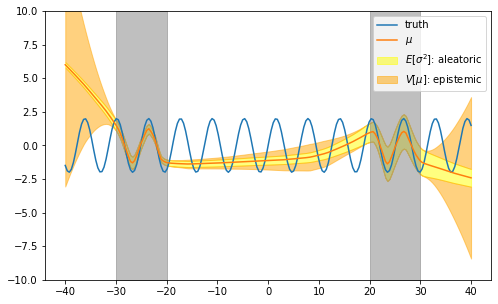

In [44]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var * scaler_y.var_
pred_ty_epistemic_var = pred_s_ty_epistemic_var * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    color="yellow", 
    alpha=0.5,
    label="$E[\sigma^2]$: aleatoric"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var - pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$V[\mu]$: epistemic"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var + pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()